# COVID Plasmas Clusters - README

Minimal notebook to reproduce the clustering and PHATE visualization presented in our paper [Sustained IFN signaling is associated with delayed development of SARS-CoV-2-specific immunity](https://www.medrxiv.org/content/10.1101/2023.06.14.23290814v1).

**Usage:** In the menu, try *Runtime > Run all*. Then make sure to upload the data file in the **Data Upload** section.


# Install Dependencies & Utilities

In [12]:
%%capture
!pip3 install phate

# Updgrade scipy
!pip install --upgrade scipy

In [13]:
!# Python imports
import os

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import numpy as np


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from phate import PHATE

from google.colab import files

In [14]:
# Function for linear correction
def linear_correction(x, Y):
  """For each column y in Y, fit a linear model xw = y and compute the
  residuals y - xw. Returns a dataframe the same shape as Y, but with
  model residuals. Missing values in Y should be unaffected."""

  if x.isna().any():
    raise ValueError("Provided input for correction should \
                      not have any missing values.")

  print(f"Correcting the measurements:\n{list(Y.columns)} \nUsing the following predictor : {x.name} ")

  # Copy targets to not affect the original dataframe
  Y = Y.copy()

  # Correct specific columns
  for y_name in Y:
    # Remove any row with missing values in target
    y = Y[y_name]
    mask = ~y.isna().to_numpy()
    x_i, y = x[mask].to_numpy().reshape((-1, 1)), y[mask]

    # Scale data
    x_i = StandardScaler().fit_transform(x_i)

    # Fit linear regression
    m = LinearRegression(fit_intercept=True)
    m.fit(x_i, y)

    # Prediction
    pred = m.predict(x_i)

    # Replace non-missing values with residuals
    Y.loc[mask, y_name] -= pred
  return Y

# Settings

In [15]:
# Settings
FILE_NAME = '20240402_Source_Data_File.xlsx'

# Column names in the file
ANTIBODIES=['RBDspecific_IgG', 'RBDspecific_IgM', 'RBDspecific_IgA']
VIRAL_LOAD=['N_copies/ml']
CYTOKINES=['TNFa', 'CXCL13', 'CCL2', 'IL6', 'IL23', 'CXCL8', 'IL1ra', 'Ang-2', 'RAGE', 'SPD']

# Concatenate all column names in a single list
INPUTS = VIRAL_LOAD + ANTIBODIES + CYTOKINES

# Time period. For example, DSO_center=11 and DSO_window=4 will keep only
# samples in the range [7, 15]. If multiple samples are present per patient,
# only the sample closest to 11 is retained.
DSO_CENTER = 11
DSO_WINDOW = 4

<a name="upload"></a>
# Data Upload

Upload data to the notebook's server. Data should be in the first tab of an .xlsx file with no password protection. Make sure to use the same file name as the one declared in the file_name
attribute of the current configuration.

In [16]:
uploaded = files.upload()
print(f"Uploaded file {FILE_NAME}")

Saving 20240402_Source_Data_File.xlsx to 20240402_Source_Data_File (1).xlsx
Uploaded file 20240402_Source_Data_File.xlsx


In [17]:
df = pd.read_excel(FILE_NAME, header=0, sheet_name=0, engine='openpyxl')

In [18]:
# Parse Assigned Name to create patient identifiers
df = df.set_index(['Center', 'Local_Code', 'DSO'], drop=False)

df

Assigned_name  Local_Code Center      Age  Sex Visit  \
Center Local_Code DSO                                                         
CHUM   1          9.0       CHUM_1_B           1   CHUM  60 - 69    F     B   
                  11.0     CHUM_1_F1           1   CHUM  60 - 69    F    F1   
       2          12.0      CHUM_2_B           2   CHUM  70 - 79    F     B   
                  14.0     CHUM_2_F1           2   CHUM  70 - 79    F    F1   
                  19.0     CHUM_2_F2           2   CHUM  70 - 79    F    F2   
...                              ...         ...    ...      ...  ...   ...   
JGH    1316       35.0   JGH_1316_F2        1316    JGH      NaN  NaN    F2   
       1328       18.0   JGH_1328_F1        1328    JGH      NaN  NaN    F1   
                  22.0   JGH_1328_F2        1328    JGH      NaN  NaN    F2   
                  29.0   JGH_1328_F3        1328    JGH      NaN  NaN    F3   
       1378       12.0    JGH_1378_B        1378    JGH      NaN  NaN     B   

                       COVID-19_Status Eligible       VAP   DSO  ...  \
Center Local_Code DSO                                            ...   
CHUM   1          9.0          POSITIF      YES  03201-20   9.0  ...   
                  11.0         POSITIF      YES  03211-20  11.0  ...   
       2          12.0         POSITIF      YES  03219-20  12.0  ...   
                  14.0         POSITIF      YES  04265-20  14.0  ...   
                  19.0         POSITIF      YES  04293-20  19.0  ...   
...                                ...      ...       ...   ...  ...   
JGH    1316       35.0         POSITIF      YES  06033-21  35.0  ...   
       1328       18.0         POSITIF      YES  06054-21  18.0  ...   
                  22.0         POSITIF      YES  06005-21  22.0  ...   
                  29.0         POSITIF      YES  06824-21  29.0  ...   
       1378       12.0         POSITIF      YES  06812-21  12.0  ...   

                                IL6          RAGE           SPD       TNFa  \
Center Local_Code DSO                                                        
CHUM   1          9.0     61.169620   5208.173379  15437.319855  26.673597   
                  11.0    25.507302   6296.211557  21614.860841  26.941767   
       2          12.0   263.024701  20271.304580  42857.079995  29.834852   
                  14.0   138.490361   7860.736612  37259.306169  27.768947   
                  19.0    15.117014   4813.920266  51525.052797  27.787653   
...                             ...           ...           ...        ...   
JGH    1316       35.0     1.472852    835.046546  33988.678579  14.043764   
       1328       18.0  1026.545031   1415.199055  59443.076953  20.319027   
                  22.0   555.087524   1262.810398  46027.260498  22.270478   
                  29.0   122.626412   1203.420472  37759.625371  16.894678   
       1378       12.0   133.343364   6521.489014  27061.646891  10.965232   

                         N_copies/ml  RBDspecific_IgG  RBDspecific_IgM  \
Center Local_Code DSO                                                    
CHUM   1          9.0   10649.000000         1.080000         0.975000   
                  11.0   3032.300000         1.080000         2.607434   
       2          12.0   5424.538123         1.080000         0.975000   
                  14.0   1363.279513         7.515377         6.149425   
                  19.0     97.581880        62.432446        18.275239   
...                              ...              ...              ...   
JGH    1316       35.0           NaN       336.317359       126.321693   
       1328       18.0    102.694359       142.664545       144.538315   
                  22.0    106.226064       188.762147       155.385485   
                  29.0     15.153533       204.116113       152.981885   
       1378       12.0           NaN       128.005373        86.487658   

                        RBDspecific_IgA  ssGSEA_COVID  ssGSEA_IFN  
Center Local

In [19]:
# Number of unique patients
(df['Center'] + df['Local_Code'].astype(str)).nunique()

305

# Sample Selection



Drop samples with missing values in input

In [20]:
df = df.dropna(subset=INPUTS)
print(df.shape)

(619, 47)


In [21]:
# Only keep D_Eligible and D_COVID-19 Status
keep_1 = df['Eligible'] == 'YES'
keep_2 = df['COVID-19_Status'] == 'POSITIF'
keep = keep_1 & keep_2

df = df[keep]
print(df.shape)


(619, 47)


For the cross-sectional data, remove samples outside of the considered timeframe.

In [22]:
dso = df['DSO']
low, high = DSO_CENTER - DSO_WINDOW, DSO_CENTER + DSO_WINDOW
keep = (dso >= low) & (dso <= high)

df = df[keep]
print(df.shape)

(364, 47)


Keep only one sample per patient. If multiple samples are present, we only keep the one closest to CONFIG['dso_center'].

In [23]:
df['dso_delta'] = (df['DSO'] - DSO_CENTER).abs()
idx = df['dso_delta'].groupby(['Center', 'Local_Code']).idxmin().dropna()
df = df.loc[idx]
print(df.shape)

(242, 48)


# Data Preprocessing


Log the input.

In [24]:
df[INPUTS] = df[INPUTS].apply(np.log10)

**Time to process correction :** Luminex concentrations (i.e., mostly cytokines) tend to decay as the processing time increases. We fit a linear model to predict the plasma measurements using time, and replace the log measurements by the model residuals. This should effectively "decorrelate" the cytokine measurements from the processing time.

In [25]:
df[CYTOKINES] = linear_correction(df["Time_To_Process(hrs)"], df[CYTOKINES])

Correcting the measurements:
['TNFa', 'CXCL13', 'CCL2', 'IL6', 'IL23', 'CXCL8', 'IL1ra', 'Ang-2', 'RAGE', 'SPD'] 
Using the following predictor : Time_To_Process(hrs) 


Standard scale the data (mean=0, standard deviation=1).

In [26]:
df[INPUTS] = StandardScaler().fit_transform(df[INPUTS])

Our cross-sectional data is ready!

In [27]:
df[INPUTS]

N_copies/ml  RBDspecific_IgG  RBDspecific_IgM  \
Center Local_Code DSO                                                   
CHUM   1          11.0     1.775687        -1.336045        -0.695922   
       2          12.0     2.020093        -1.336045        -1.326206   
       4          12.0    -0.806701         0.969541         0.504593   
       5          13.0    -0.400229         1.221133         0.719931   
       7          11.0     1.102910        -0.550904        -0.291106   
...                             ...              ...              ...   
JGH    806        9.0      0.224381        -1.336045        -0.503511   
       809        8.0     -0.806701         0.365254        -1.326206   
       1192       12.0     1.046738         1.632747         2.657003   
       1193       12.0     1.640228         0.298743         0.854373   
       1307       11.0     1.385030         0.561490         0.624910   

                        RBDspecific_IgA      TNFa    CXCL13      CCL2  \
Center Local_Code DSO                                                   
CHUM   1          11.0        -1.329665  1.682858  3.484360  1.546542   
       2          12.0        -0.431116  1.782348  0.851646  1.784940   
       4          12.0         0.795817  0.943131 -0.246824  1.824512   
       5          13.0         1.523908 -0.126449 -1.124589  0.499835   
       7          11.0        -0.795845  0.322218 -0.284512  1.359224   
...                                 ...       ...       ...       ...   
JGH    806        9.0         -1.329665  0.241584 -0.625180  0.715370   
       809        8.0         -0.326968  0.424977 -0.116725 -0.689089   
       1192       12.0         1.511399  1.428805  2.323012  0.693398   
       1193       12.0        -1.329665 -1.252159  0.325348 -0.518661   
       1307       11.0        -1.329665  2.061849  1.116556  2.574924   

                             IL6      IL23     CXCL8     IL1ra     Ang-2  \
Center Local_Code DSO                                                      
CHUM   1          11.0  0.315924  0.229466  1.774275  0.651403  1.125942   
       2          12.0  1.809002  1.680693  1.326664  1.853271  1.395857   
       4          12.0  1.759232  1.447212  0.826879  1.030745  0.078857   
       5          13.0 -0.884131 -0.918548 -1.278597 -0.022514  0.320749   
       7          11.0  0.792937 -1.001205  1.362360  1.005289 -1.022613   
...                          ...       ...       ...       ...       ...   
JGH    806        9.0   0.375216  0.436172  0.367724 -0.916173 -0.753200   
       809        8.0  -1.437347 -0.538763 -1.437554 -1.501677  1.109754   
       1192       12.0 -0.030510  1.925457 -0.035398  0.340311  1.644576   
       1193       12.0 -0.233815  1.112774 -0.420581 -0.408096  0.019889   
       1307       11.0  3.010211  2.390436  2.393834  1.640090  0.112074   

                            RAGE       SPD  
Center Local_Code DSO                       
CHUM   1          11.0  0.894064  0.735205  
       2          12.0  2.218067  1.332103  
       4          12.0 -0.179514  0.329739  
       5          13.0 -0.983107  0.194054  
       7          11.0  1.087629 -2.019637  
...                          ...       ...  
JGH    806        9.0  -0.133637  0.657590  
       809        8.0   1.556860 -0.376522  
       1192       12.0 -0.563006  1.217911  
       1193       12.0  0.620084 -0.250069  
       1307       11.0  1.215966  0.842431  

[242 rows x 14 columns]

# Fit PHATE and k-Means
Fit PHATE, PCA, k-Means and save results to the main dataframe.

In [28]:
# Get only the input columns
X_in = df[INPUTS].copy()

# Dimensionality reduction
phate_op = PHATE(t=50, knn=10, n_components=2, n_jobs=-1, random_state=123)
df[['PHATE_1', 'PHATE_2']] = phate_op.fit_transform(X_in)

# Clustering
model_clr = KMeans(n_clusters=4, random_state=123)
df['cluster'] = model_clr.fit_predict(X_in)

Calculating PHATE...
  Running PHATE on 242 observations and 14 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.04 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.05 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.14 seconds.
Calculated PHATE in 0.26 seconds.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [29]:
# Flip axes to match the orientation we have in the paper
df['PHATE_1'] *= -1
df['PHATE_2'] *= -1

# Remap clusters to match the ordering in the paper
df['cluster'] = df['cluster'].map({0:3, 1:1, 2:0, 3:2})

<a name="plots"></a>
# Plots

Simplest plots you can make. See the other notebook for all the fancy options to make things pretty.


Text(0, 0.5, 'PHATE 2')

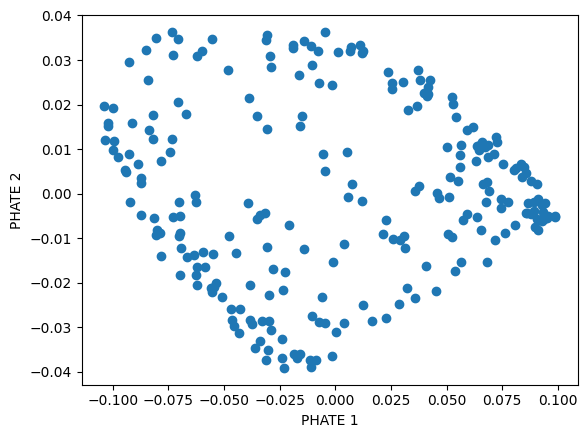

In [30]:
# Scatter plot with no color
plt.scatter(df['PHATE_1'], df['PHATE_2'])
plt.xlabel('PHATE 1')
plt.ylabel('PHATE 2')

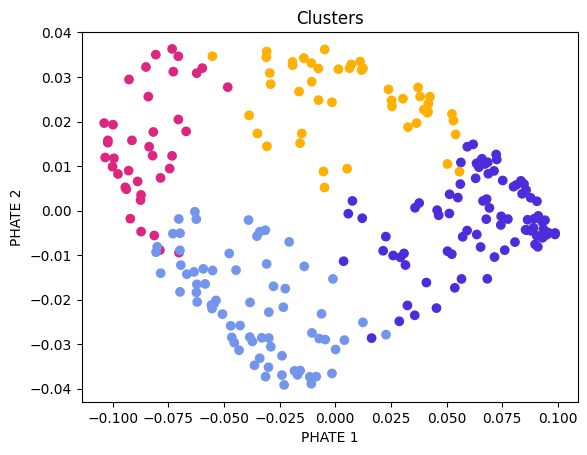

In [31]:
# Scatter plot with clusters as color
cm = LinearSegmentedColormap.from_list("my_list", ['#DC267F', '#FFB000', '#7395EC', '#4C2DDC'])
plt.scatter(df['PHATE_1'], df['PHATE_2'], c=df['cluster'], cmap=cm)

# Titles and axis
plt.title('Clusters')
plt.xlabel('PHATE 1')
plt.ylabel('PHATE 2')

plt.show()

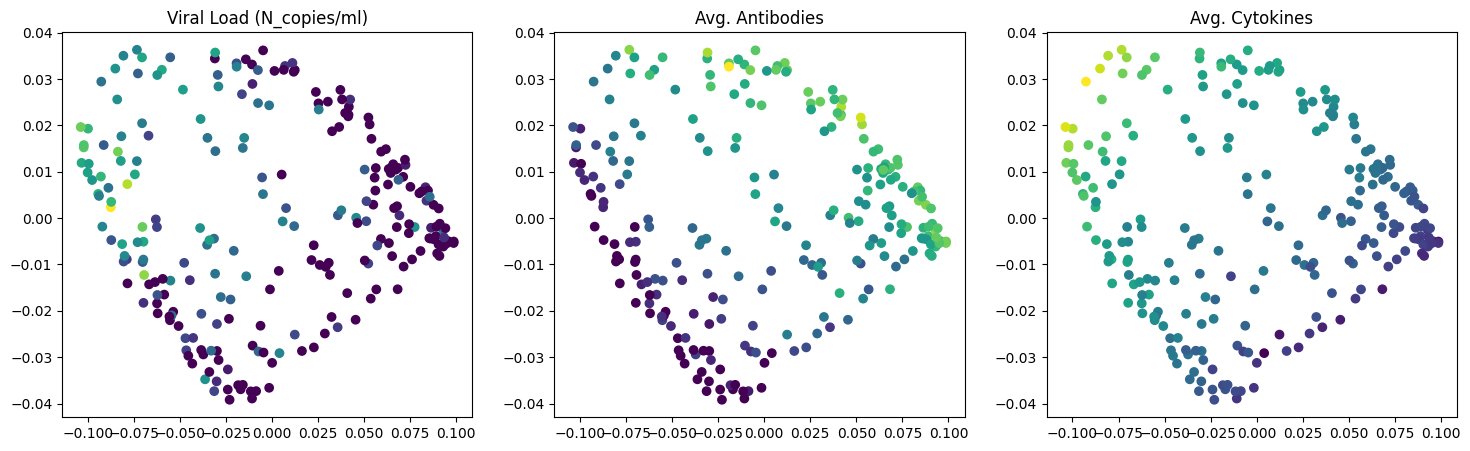

In [32]:
# Explore input features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

vl = df['N_copies/ml']
avg_ant = df[ANTIBODIES].mean(axis=1)
avg_cyto = df[CYTOKINES].mean(axis=1)

axes[0].scatter(df['PHATE_1'], df['PHATE_2'], c=vl)
axes[0].set_title("Viral Load (N_copies/ml)")

axes[1].scatter(df['PHATE_1'], df['PHATE_2'], c=avg_ant)
axes[1].set_title("Avg. Antibodies")

axes[2].scatter(df['PHATE_1'], df['PHATE_2'], c=avg_cyto)
axes[2].set_title("Avg. Cytokines")

plt.show()

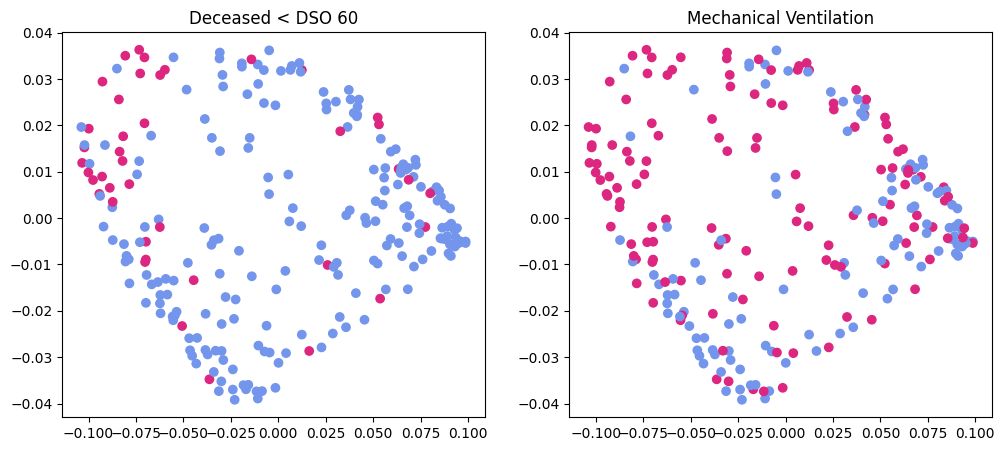

In [33]:
# Explore patient outcomes
cm = LinearSegmentedColormap.from_list("my_list", ['#7395EC', '#DC267F'])
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

mechanical_ventilation = df['RespSupp_Sampling_Name'].isin(['SEVERE', 'CRITICAL'])
deceased = df["Deceased"]


axes[0].scatter(df['PHATE_1'], df['PHATE_2'], c=deceased, cmap=cm)
axes[0].set_title("Deceased < DSO 60")

axes[1].scatter(df['PHATE_1'], df['PHATE_2'], c=mechanical_ventilation, cmap=cm)
axes[1].set_title("Mechanical Ventilation")

plt.show()